# Dataset project - No-show appointments

I have chosen the No-show appointments dataset originally provided on Kaggle (see https://www.kaggle.com/joniarroba/noshowappointments) as the material for my project work. The version of the dataset that I am using collects information about 110,000+ doctor's appointments made during 2016 in the city of Vitoria in Brazil. Besides the relevant details of the appointments themselves it also includes data about the patients' health and social background. In my analyses of the data I will try to identify which factors seem to be associated with a greater likelihood of patients missing their doctor's appointment.

## Table of contents
<ul>
<li><a href="#prep">Preparation of the data</a>
<li><a href="#recode">Recoding data</a>
<li><a href="#analyse">Analysing the data</a>
<li><a href="#limits">Limitations</a>
<li><a href="#summ">Summary</a>
<li><a href="#reso">Resources</a>
</ul>

<a id="prep"></a>
## Preparation of the data

The first steps in the analysis of the data are of course importing the necessary Python libraries, reading the data into a Pandas dataframe and initial examinations of the data to familiarize myself with its features.

In [1]:
# Importing the NumPy, pandas, and Matplotlib libraries
# and then reading the data into a dataframe.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

# Printing the first ten rows of the dataset, information about 
# the variables in the dataset, and the sum of duplicate rows in the dataset.

print(df.head(10))
print(df.info())
print(sum(df.duplicated()))

      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   
5  9.598513e+13        5626772      F  2016-04-27T08:36:51Z   
6  7.336882e+14        5630279      F  2016-04-27T15:05:12Z   
7  3.449833e+12        5630575      F  2016-04-27T15:39:58Z   
8  5.639473e+13        5638447      F  2016-04-29T08:02:16Z   
9  7.812456e+13        5629123      F  2016-04-27T12:48:25Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0            

Like the info listing on the dataframe above shows, there are no missing values in the data and it doesn't contain any duplicate rows either. Still, the data needs some trimming and recoding in order to make working with it easier and to get the most out of it. Alongside these operations I am printing relevant information about the dataset and its variables as a means to check the results of the operations.

As a first step I am converting all of the column labels to lowercase for easier referral. The hyphen in the label of the `'No-show'` column might also cause problems if left there.

In [2]:
# Making all of the column names lower-case and replacing the hyphen
# with an underscore, then reprinting information about the variables.

df.rename(columns=lambda x: x.strip().lower().replace("-","_"), inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patientid         110527 non-null float64
appointmentid     110527 non-null int64
gender            110527 non-null object
scheduledday      110527 non-null object
appointmentday    110527 non-null object
age               110527 non-null int64
neighbourhood     110527 non-null object
scholarship       110527 non-null int64
hipertension      110527 non-null int64
diabetes          110527 non-null int64
alcoholism        110527 non-null int64
handcap           110527 non-null int64
sms_received      110527 non-null int64
no_show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None


The next step to be considered is whether all of the variables in the dataset are useful and practical for my analyses. While the data probably includes patients with more than one appointment during the observation period, using that information is unfortunately not feasible in the framework of this project. To make use of the `'patientid'` variable would require rather complex recoding of the data and there might also be inconsistencies in the recorded values of the other variables between different visits that would have to be accounted for.

Another variable that might provide interesting results but is unfortunately not usable in my project is the `'neighbourhood'` column. Since meaningful analyses with that variable would require a good deal of research into the characteristics of the different neighborhoods (81 in total), using that variable is not practical in this context.

Thus, I am dropping these two columns from the dataframe. The `'appointmentid'` column can be also dropped as redundant, since Pandas indexes the dataframe rows automatically.

In [3]:
# Dropping redundant columns from the dataset
# and once again reprinting information about variables.

df.drop(labels=['patientid', 'appointmentid', 'neighbourhood'], axis=1, inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 11 columns):
gender            110527 non-null object
scheduledday      110527 non-null object
appointmentday    110527 non-null object
age               110527 non-null int64
scholarship       110527 non-null int64
hipertension      110527 non-null int64
diabetes          110527 non-null int64
alcoholism        110527 non-null int64
handcap           110527 non-null int64
sms_received      110527 non-null int64
no_show           110527 non-null object
dtypes: int64(7), object(4)
memory usage: 9.3+ MB
None


<a id="recode"></a>
## Recoding data

Next, I am recoding some of the variables in order to make them easier and more practical to work with. According to the dataset description in Kaggle, the `'handcap'` variable measures the number of handicaps each patient has. However, as this level of detail is not necessary for my analyses, I will recode that variable into a binary scale.

In [4]:
# Recoding the handicap variable into a binary scale with the
# .transform method and a lambda function, then printing its value counts.

df['handcap'] = df['handcap'].transform(lambda x: 1 if (x>0) else 0);

print(df['handcap'].value_counts())

0    108286
1      2241
Name: handcap, dtype: int64


One question that might be worth examining is whether the day of the week the appointment is scheduled for is associated with the likelihood of the patient not showing up. Extracting the day of the week from the `'appointmentday'` variable can be easily done with Python's `.strftime()` method. But since the variable shows up as an object in the datatype listing, its values need first to be cast as proper datetimes object with Pandas' `.astype()` method.

In [5]:
# Casting the day of the appointment as a datetime object and
# extracting the day of the week with the .strftime method into
# a new variable, then printing the variable's value counts.

df['app_weekday'] = df['appointmentday'].astype('datetime64[ns]').apply(lambda x: x.strftime('%A'))

print(df['app_weekday'].value_counts())

Wednesday    25867
Tuesday      25640
Monday       22715
Friday       19019
Thursday     17247
Saturday        39
Name: app_weekday, dtype: int64


The time the patient needs to wait after scheduling their appointment might also be a factor in not showing up. This can be measured by substracting the date that the appointment was first scheduled on from the appointment date itself. As the subtraction operation returns a timedelta, I also need to use the `.days` method on the new variable to transform it into the number of days between the scheduling and appointment, which is a more usable metric. For examing the value distribution of the new variable I am using custom percentiles for reasons which become apparent below.

In [6]:
# Calculating the timedelta of the time that patients need to wait
# for their appointment with a vectorized operation using the variables
# for the appointment day and the day that the appointment was scheduled
# cast as datetime objects. Then using the .days method to recode
# the timedelta into an integer variable for the number of days.
# Finally, printing this variable's value distribution.

df['days_between'] = np.subtract(df.loc[:, 'appointmentday'].astype('datetime64[ns]'),
                                 df.loc[:, 'scheduledday'].astype('datetime64[ns]'))
df['days_between'] = df['days_between'].apply(lambda x: x.days)

print(df['days_between'].describe(percentiles=[.01, .33, .5, .75]))

count    110527.000000
mean          9.183702
std          15.254996
min          -7.000000
1%           -1.000000
33%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: days_between, dtype: float64


The value distribution for the `'days_between'`column shows that there is a significant amount of appointments where the difference between the scheduling date and the appointment date is a negative number. These are most probably due to errors in the recording of either `'scheduledday'` or `'appointmentday'`. Since the number of appointments with negative waiting time amount to more than third of the observations, simply dropping these rows is not a good option. As most of these negative values don't go below -1, I think the most straightforward and the least skewing way to deal with them is to convert them to zeroes.

In [7]:
# Recoding the waiting time variable's below-zero values
# into zeroes with the .apply method and a lambda function,
# then reprinting the variable's value distribution.

df['days_between'] = df['days_between'].apply(lambda x: 0 if (x<0) else x)

print(df['days_between'].describe(percentiles=[.01, .33, .5, .75]))

count    110527.000000
mean          9.532739
std          15.027729
min           0.000000
1%            0.000000
33%           0.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: days_between, dtype: float64


<a id="analyse"></a>
## Analysing the data

Now I will move on to the actual analysis of the data to identify which factors are associated with a greater likelihood of the patient missing their doctor's appointment. The description of the dataset notes that 'No' values in the `'no-show'` column indicate that the patient had their appointment normally while 'Yes' means that they missed it. As the first step of the analysis, I am plotting a pie chart to get an idea of the overall proportion of no-show appointments in the dataset.

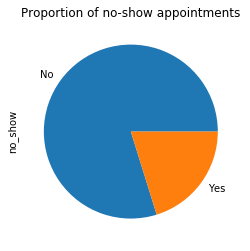

In [8]:
# Invoking the 'magic word' that will show plotted charts in the output.

%matplotlib inline

# Plotting a pie chart of for the overall now-show level in the data.

ax = df['no_show'].value_counts().plot(kind='pie', title='Proportion of no-show appointments')
ax.set_aspect('equal')

As the pie chart shows, the ratio of no-show appointments is about one-fifth of them, which seems like a rather large proportion. To get a more precise sense of the no-show proportion I am printing the value counts for no-show appointments and calculating their exact overall ratio to provide a baseline for further analyses

In [9]:
# Printing the exact value counts for the no-show column
# as well as calculating the overall no-show level in the dataset.

print(df['no_show'].value_counts())
print((df['no_show'].value_counts()[1]) / df['no_show'].shape[0])

No     88208
Yes    22319
Name: no_show, dtype: int64
0.201932559465


Next I will do some exploratory data analysis to see if there is any deviation in the no-show ratio from the baseline established above when observing the ratio in relation to the other variables. For that purpose I am first crosstabulating the `'no_show'` column with the categorical background variables - that is, the patient's gender and welfare scholarship status, the presence of hypertension, diabetes, alcoholism, or handicap, the day of the week of the appointment and whether or not the patient received an SMS prior to their appointment.

In [10]:
# Grouping into a list the categorical independent variables,
# which relationship to the no-show variable I shall explore.

indep_variables = ['gender', 'scholarship', 'hipertension', 'diabetes',
                   'alcoholism', 'handcap', 'app_weekday', 'sms_received']

# Using a for loop to print the cross-tabulations of the no-show
# variable and the categorical independent variables.

for item in indep_variables:
    print(pd.crosstab(df['no_show'], [df[item]], normalize='columns'))
    print("\n")

gender          F         M
no_show                    
No       0.796854  0.800321
Yes      0.203146  0.199679


scholarship         0         1
no_show                        
No           0.801928  0.762637
Yes          0.198072  0.237363


hipertension         0        1
no_show                        
No            0.790963  0.82698
Yes           0.209037  0.17302


diabetes         0         1
no_show                     
No        0.796372  0.819967
Yes       0.203628  0.180033


alcoholism         0         1
no_show                       
No          0.798054  0.798512
Yes         0.201946  0.201488


handcap         0         1
no_show                    
No       0.797647  0.818385
Yes      0.202353  0.181615


app_weekday    Friday    Monday  Saturday  Thursday   Tuesday  Wednesday
no_show                                                                 
No           0.787739  0.793529  0.769231  0.806459  0.799064   0.803108
Yes          0.212261  0.206471  0.230769  0.1935

For gender, alcoholism, and the day of the week there are no significant differences in the no-show ratio between the categories of these independent variables. Saturday appointments have a somewhat higher no-show ratio than weekdays, but these appointments consist only of 39 cases in the whole dataset, so this observation is not particularly significant. As for the other variables, patients whose families receive the welfare scholarship are somewhat more likely to miss their appointments than those who don't receive it. On the other hand, those patients with hypertension, diabetes or handicap have a slightly smaller ratio of no-show appointments than the baseline.

But the variable which shows the largest difference in terms of no-show ratio is whether the patient received an SMS prior to their doctor's appointment. However, the data seems to indicate that those patients who did receive a text message were much more likely to miss their appointment than those who didn't, which is rather curious. For the moment, though, I am setting this puzzling observation aside and will return to it a bit later.

Next I will move on to examine the no-show appointments in relation to the two remaining variables, the age of the patients and the number of days the patients need to wait for their appointment. I will use boxplot visualizations and value distributions to see whether there can be observed any association between the no-show appointments and the two continuos variables.

/home/mailjo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


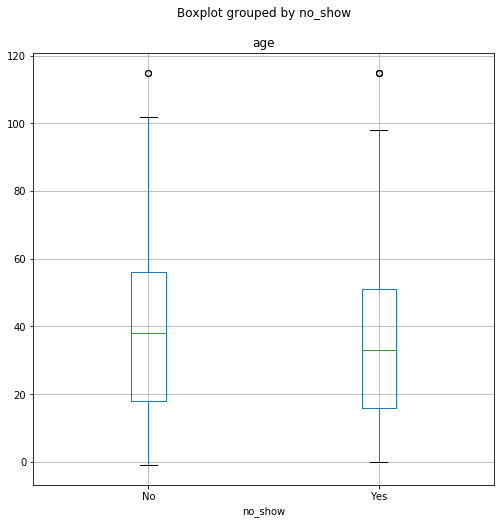

In [11]:
# Plotting a boxplot chart of the age variable,
# grouped by the categories of the no-show variable.

df.boxplot(column='age', by='no_show', figsize=(8,8));

In [12]:
# Printing the value distribution of the age variable,
# grouped by the categories of the no-show variable.

df['age'].groupby(df['no_show']).describe()

,count,mean,std,min,25%,50%,75%,max
no_show,,,,,,,,
No,88208.0,37.790064,23.338878,-1.0,18.0,38.0,56.0,115.0
Yes,22319.0,34.317667,21.965941,0.0,16.0,33.0,51.0,115.0


According to the boxplots those patients that missed their appointments tend to be younger than those who did not. This is shown more precisely in the age distributions grouped by the no-show status. Both the mean and the median are a couple of years lower for the patients missing their appointment than for the patients showing up normally.

/home/mailjo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


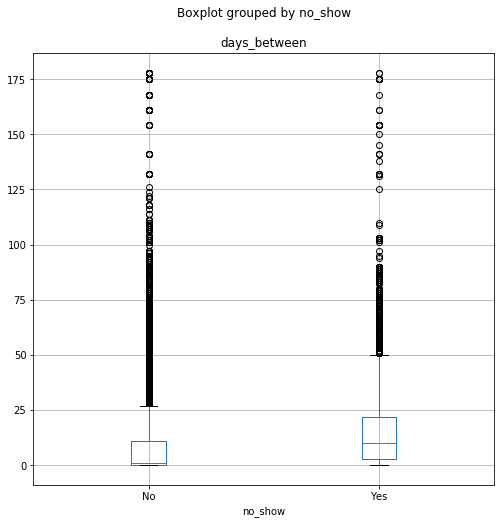

In [13]:
# Plotting a boxplot chart of the waiting time variable,
# grouped by the categories of the no-show variable.

df.boxplot(column='days_between', by='no_show', figsize=(8,8));

In [14]:
# Printing the value distribution of the waiting time variable,
# grouped by the categories of the no-show variable.

df['days_between'].groupby(df['no_show']).describe()

,count,mean,std,min,25%,50%,75%,max
no_show,,,,,,,,
No,88208.0,8.171526,14.305874,0.0,0.0,1.0,11.0,178.0
Yes,22319.0,14.912451,16.530724,0.0,3.0,10.0,22.0,178.0


As for the `'days_between'` variable, the boxplots and value distributions grouped by the no-show status seem to indicate quite clearly that missing the appointment is associated with longer waiting periods. The mean and the median for the number of days between the scheduling and the appointment are much larger in the group that missed their appointments than those who did not.

When grouped also by the `'sms_received'` variable, the association between the waiting period and the no-show status sheds light also on the peculiar observation made above that patients receiving an SMS are more likely to miss their appointment. As shown in the cell below, the patients receiving the text messages tend to be those with longer waiting periods before their appointment. Thus, the puzzling observation seems to be simply an artefact that arises as a side effect of the association between the waiting period and the no-show status.

In [15]:
# Printing the value distribution of the waiting time variable,
# grouped by the categories of the no-show and text message variables.

df['days_between'].groupby([df['no_show'], df['sms_received']]).describe()

count       mean        std  min  25%   50%   75%  \
no_show sms_received                                                        
No      0             62510.0   4.279203  10.883614  0.0  0.0   0.0   2.0   
        1             25698.0  17.639544  16.966504  2.0  5.0  13.0  26.0   
Yes     0             12535.0  11.716235  15.441773  0.0  1.0   6.0  19.0   
        1              9784.0  19.007359  16.971748  2.0  6.0  14.0  27.0   

                        max  
no_show sms_received         
No      0             178.0  
        1             178.0  
Yes     0             178.0  
        1             178.0

<a id="limits"></a>
## Limitations

As noted when preparing the data, the dataset doesn't contain any missing values. In that respect observations about the data can be considered reliable. However, another factor in the data makes it clear that there are other issues that undermine the reliability of the observations. The negative values that appeared when calculating the patients' waiting time for their appointments point to evident problems in the recording of the data. Whether these errors are random or somehow systematic is a question that is too wide-reaching to assess in the scope of this project. But it is undeniable that they reduce the reliability of the observations made about the data and the conclusions that can be drawn from those observations.

It should be also noted that the analyses I have made on the data have been purely descriptive and have not utilized any statistical tests or other more advanced methods. Thus the conclusions in the following section should be regarded at most as tentative and mainly indicating possible avenues for further, more detailed analyses.

<a id="summ"></a>
## Summary

The preceding examinations identified certain factors that were variously associated with the likelihood of the patients missing their appointment. Patients with diabetes, hypertension, or handicaps had smaller no-show ratios than those with not. On the other hand, those patients who missed their appointments had lower mean and median age than those who did not.  These findings would point to a conclusion that patients with more reason to care about their health - due to a longterm condition or advanced age - are less likely to miss their medical appointment. Also, patients in the welfare scholarship program had a higher no-show ratio, which might indicate that the financial constraints they face could affect their likelihood to utilise health services.

But the largest observed differences between the patients showing up and those who missed their appointments were in their waiting periods. This could be due to a number of different factors, such as patients forgetting about the appointment while waiting, subsequent schedule conflicts forcing the patient to miss the appointment, or the problem for which the appointment was made getting better on its own. While the negative values in the waiting times discussed above obviously make this association somewhat problematic, the value distributions between the patients showing up and those missing their appointments differ so clearly that the association can be considered to have at least some merit to it.

<a id="reso"></a>
## Resources

The Kaggle webpage for the No-show dataset, Pandas and Matplotlib documentation, as well as Stack Overflow were frequently consulted while working on the project.